In [1]:
%cd ../..
%load_ext autoreload
%autoreload 2

/home/jupyter/map-ephys


In [9]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from pipeline import lab, experiment, ephys, psth_foraging, foraging_analysis, histology

import plotly.graph_objs as go
from plotly.offline import iplot
import plotly.express as px

foraging_sessions = (foraging_analysis.SessionTaskProtocol & 'session_task_protocol=100').proj()
import datajoint as dj; dj.conn().connect()

# Add choices and autoregression into linear regression

In [6]:
psth_foraging.UnitPeriodLinearFit.progress()

UnitPeriodLinearFit  Completed 714777 of 714777 (100.0%)   2023-03-29 19:08:31


(0, 714777)

In [15]:
psth_foraging.IndependentVariable()

*var_name                    desc                          
+--------------------------+ +----------------------------+
choice_ic                    ipsi (0) or contra (1)        
choice_ic_next               ipsi (0) or contra (1), next c
choice_lr                    left (0) or right (1)         
contra_action_value          contra action_value           
contra_choice_kernel         contra choice_kernel          
contra_choice_prob           contra choice_prob            
firing_1_back                firing rate of 1 trials back  
firing_2_back                firing rate of 2 trials back  
firing_3_back                firing rate of 3 trials back  
firing_4_back                firing rate of 4 trials back  
firing_5_back                firing rate of 5 trials back  
ipsi_action_value            ipsi action_value             
ipsi_choice_kernel           ipsi choice_kernel            
ipsi_choice_prob             ipsi choice_prob              
left_action_value            left action_value             
left_choice_kernel           left choice_kernel            
left_choice_prob             left choice_prob              
relative_action_value_ic     relative action value (Q_contr
relative_action_value_lr     relative action value (Q_r - Q
reward                       miss (0) or hit (1)           
right_action_value           right action_value            
right_choice_kernel          right choice_kernel           
right_choice_prob            right choice_prob             
rpe                          outcome - Q_chosen            
total_action_value           total action value (Q_r + Q_l)
trial_normalized             trial number normalized to [0,
 (Total: 26)

In [26]:
psth_foraging.LinearModel.load()
psth_foraging.LinearModel()

*multi_linear_model            if_intercept    
+----------------------------+ +--------------+
dQ, sumQ, rpe, C*2             1               
dQ, sumQ, rpe, C*2, R*1        1               
dQ, sumQ, rpe, C*2, R*1, t     1               
dQ, sumQ, rpe, C*2, R*5, t     1               
dQ, sumQ, rpe, C*2, t          1               
Q_c + Q_i + rpe                1               
Q_l + Q_r + rpe                1               
Q_rel + Q_tot + rpe            1               
 (Total: 8)

## Debug fitting

In [27]:
date, imec, unit = '2021-04-18', 0, 541
unit_key = (ephys.Unit() & (experiment.Session & 'session_date = "2021-04-18"' & 'subject_id = 473361') & {'insertion_number': imec + 1, 'unit_uid': unit}).fetch1("KEY")
key = {**unit_key, 'period': "iti_all", 'multi_linear_model': "dQ, sumQ, rpe, C*2"}    

In [39]:
key = {'subject_id': 473360, 'session': 49, 'insertion_number': 1, 'clustering_method': 'kilosort2', 'unit': 187, 'period': 'delay', 'behavior_model': 'best_aic', 'multi_linear_model': 'dQ, sumQ, rpe, C*2'}

In [3]:
psth_foraging.UnitPeriodLinearFit.delete()

[2023-03-30 01:26:39,065][INFO]: Deleting 93632 rows from `map_v2_psth_foraging`.`__unit_period_linear_fit__param`
[2023-03-30 01:26:39,806][INFO]: Deleting 17024 rows from `map_v2_psth_foraging`.`__unit_period_linear_fit`


Deletes committed.


17024

In [28]:
len(psth_foraging.UnitPeriodLinearFit())

17304

In [31]:
psth_foraging.UnitPeriodLinearFit & 'period = "iti_all"'

*subject_id    *session    *insertion_number    *clustering_method    *unit    *period     *behavior_model    *multi_linear_model            actual_behavior_model     model_r2     model_r2_adj     model_p        model_bic     model_aic    
+------------+ +---------+ +------------------+ +-------------------+ +------+ +---------+ +----------------+ +----------------------------+ +-----------------------+ +----------+ +--------------+ +------------+ +-----------+ +-----------+
473361         47          1                    kilosort2             541      iti_all     best_aic           dQ, sumQ, rpe, C*2             16                        0.579215     0.574134         0.0            2892.07       2867.83      
473361         47          1                    kilosort2             541      iti_all     best_aic           dQ, sumQ, rpe, C*2, R*1        16                        0.63542      0.630111         0.0            2831.58       2803.32      
473361         47          1                    kilosort2             541      iti_all     best_aic           dQ, sumQ, rpe, C*2, R*1, t     16                        0.66198      0.656223         0.0            2805.93       2773.63      
473361         47          1                    kilosort2             541      iti_all     best_aic           dQ, sumQ, rpe, C*2, R*5, t     16                        0.662665     0.653457         0.0            2804.22       2755.88      
473361         47          1                    kilosort2             541      iti_all     best_aic           dQ, sumQ, rpe, C*2, t          16                        0.634914     0.62961          0.0            2838.48       2810.19      
473361         47          1                    kilosort2             541      iti_all     best_aic           Q_c + Q_i + rpe                16                        0.395207     0.390856         2.8026e-45     3038.52       3022.35      
473361         47          1                    kilosort2             541      iti_all     best_aic           Q_l + Q_r + rpe                16                        0.395207     0.390856         2.8026e-45     3038.52       3022.35      
473361         47          1                    kilosort2             541      iti_all     best_aic           Q_rel + Q_tot + rpe            16                        0.395207     0.390856         2.8026e-45     3038.52       3022.35      
 (Total: 8)

In [75]:
psth_foraging.schema.jobs.delete()

In [78]:
dj.U('host').aggr(psth_foraging.schema.jobs, n='COUNT(*)')

*host    n    
+------+ +---+

 (Total: 0)

# Fetch unit period linear fit data

In [6]:
unit_to_export =  (ephys.UnitForagingQC & 'unit_minimal_session_qc = 1'
                  & histology.ElectrodeCCFPosition.ElectrodePosition    # With ccf
                  - experiment.PhotostimForagingTrial)  # Without photostim

In [417]:
unit_key_names = ['subject_id', 'session', 'insertion_number', 'unit']

model_order = ['dQ, sumQ, rpe', 
               'dQ, sumQ, rpe, C*2', 
               'dQ, sumQ, rpe, C*2, t', 
               'dQ, sumQ, rpe, C*2, R*1', 
               'dQ, sumQ, rpe, C*2, R*1, t',
               'dQ, sumQ, rpe, C*2, R*5, t',
               'contraQ, ipsiQ, rpe',
               'leftQ, rightQ, rpe']

periods = ['before_2', 'iti_all', 'go_to_end']

#### Fetch model stats (master table)

In [281]:
df_period_linear_fit = (psth_foraging.UnitPeriodLinearFit & unit_to_export & 'period in ("before_2", "iti_all", "go_to_end")').fetch(format='frame')

#### Fetch all params (part table)

In [286]:
df_period_linear_fit_params = (psth_foraging.UnitPeriodLinearFit.Param & unit_to_export & 'period in ("before_2", "iti_all", "go_to_end")').fetch(format='frame')

#### Processing master table

In [282]:
rel_bic = df_period_linear_fit.groupby(unit_key_names + ['period']).apply(lambda x: x.model_bic - x.query('multi_linear_model == "Q_rel + Q_tot + rpe"').model_bic.values)
df_period_linear_fit['rel_bic'] = rel_bic.values

In [283]:
# Discard garbage
df_period_linear_fit = df_period_linear_fit.droplevel(level=['behavior_model', 'clustering_method'], axis=0)
df_period_linear_fit.drop(columns=['actual_behavior_model'], inplace=True)

In [418]:
# Pivot table
df_period_linear_fit_pivot = df_period_linear_fit.unstack(level=['period', 'multi_linear_model']
                                                         ).reorder_levels([1, 2, 0], axis='columns'
                                                                      ).sort_index(axis='columns', level=[0, 1]
                                                                                  ).rename(columns={'Q_rel + Q_tot + rpe': 'dQ, sumQ, rpe',
                                                                                                             'Q_c + Q_i + rpe': 'contraQ, ipsiQ, rpe',
                                                                                                             'Q_l + Q_r + rpe': 'leftQ, rightQ, rpe',}
                                                                                          ).reindex(model_order, axis=1, level=1
                                                                                                   )
df_period_linear_fit_pivot

period                                        before_2            \
multi_linear_model                       dQ, sumQ, rpe             
                                             model_aic model_bic   
subject_id session insertion_number unit                           
473360     49      2                0          7407.63   7426.10   
                                    13         3395.90   3414.37   
                                    16         2246.13   2264.60   
                                    24         2467.70   2486.17   
                                    25         3045.54   3064.02   
...                                                ...       ...   
494691     18      3                72         2447.42   2465.31   
                                    80         3264.44   3282.33   
                                    90         3086.68   3104.57   
                                    92         3270.96   3288.85   
                                    109        3177.27   3195.16   

period                                                                         \
multi_linear_model                                                              
                                               model_p  model_r2 model_r2_adj   
subject_id session insertion_number unit                                        
473360     49      2                0     2.169780e-01  0.005949     0.001946   
                                    13    9.924310e-02  0.008374     0.004380   
                                    16    3.732350e-01  0.004179     0.000169   
                                    24    1.216180e-01  0.007753     0.003758   
                                    25    4.489000e-01  0.003548    -0.000465   
...                                                ...       ...          ...   
494691     18      3                72    8.202310e-03  0.018129     0.013548   
                                    80    4.803620e-05  0.034568     0.030064   
                                    90    1.401300e-45  0.279660     0.276299   
                                    92    0.000000e+00  0.495436     0.493082   
                                    109   0.000000e+00  0.337576     0.334485   

period                                                                         \
multi_linear_model                               dQ, sumQ, rpe, C*2             
                                         rel_bic          model_aic model_bic   
subject_id session insertion_number unit                                        
473360     49      2                0        0.0            7398.75   7426.45   
                                    13       0.0            3389.38   3417.08   
                                    16       0.0            2242.60   2270.30   
                                    24       0.0            2468.46   2496.17   
                                    25       0.0            3041.20   3068.91   
...                                          ...                ...       ...   
494691     18      3                72       0.0            2441.17   2468.00   
                                    80       0.0            3250.72   3277.55   
                                    90       0.0            3072.14   3098.96   
                                    92       0.0            3249.47   3276.30   
                                    109      0.0            3168.47   3195.30   

period                                                        ...  \
multi_linear_model                                            ...   
                                           model_p  model_r2  ...   
subject_id session insertion_number unit                      ...   
473360     49      2                0     0.268825  0.008577  ...   
                                    13    0.033912  0.016096  ...   
                                    16    0.125420  0.011521  ...   
                                    24    0.270476  0.008552  ..

#### Processing part table

In [ ]:
# Discard garbage
df_period_linear_fit_params = df_period_linear_fit_params.droplevel(level=['clustering_method'], axis=0)
df_period_linear_fit_params

In [298]:
df_period_linear_fit_params

beta  \
subject_id session insertion_number unit period   multi_linear_model  var_name                             
473360     49      2                0    before_2 dQ, sumQ, rpe, C*2  choice_ic                -3.100310   
                                                                      choice_ic_next            4.138150   
                                                                      relative_action_value_ic  4.861500   
                                                                      rpe                       1.346350   
                                                                      total_action_value       -2.736370   
...                                                                                                  ...   
494691     18      3                109  iti_all  Q_l + Q_r + rpe     right_action_value        4.411000   
                                                                      rpe                       0.048679   
                                                  Q_rel + Q_tot + rpe relative_action_value_ic -0.947059   
                                                                      rpe                       0.048679   
                                                                      total_action_value        5.358060   

                                                                                                 std_err  \
subject_id session insertion_number unit period   multi_linear_model  var_name                             
473360     49      2                0    before_2 dQ, sumQ, rpe, C*2  choice_ic                 3.546440   
                                                                      choice_ic_next            3.105870   
                                                                      relative_action_value_ic  3.197690   
                                                                      rpe                       2.476910   
                                                                      total_action_value        5.418980   
...                                                                                                  ...   
494691     18      3                109  iti_all  Q_l + Q_r + rpe     right_action_value        0.759601   
                                                                      rpe                       0.165617   
                                                  Q_rel + Q_tot + rpe relative_action_value_ic  0.466442   
                                                                      rpe                       0.165617   
                                                                      total_action_value        0.350129   

                                                                                                           p  \
subject_id session insertion_number unit period   multi_linear_model  var_name                                 
473360     49      2                0    before_2 dQ, sumQ, rpe, C*2  choice_ic                 3.822910e-01   
                                                                      choice_ic_next            1.831500e-01   
                                                                      relative_action_value_ic  1.288580e-01   
                                                                      rpe                       5.869070e-01   
                                                                      total_action_value        6.137370e-01   
...                                                                                                      ...   
494691     18      3                109  iti_all  Q_l + Q_r + rpe     right_action_value        9.999890e-09   
                                                                      rpe                       7.689120e-01   
                                                  Q_rel + Q_tot + rpe relative_action_value_ic  4.272810e-02   
                                                          

In [419]:
df_period_linear_fit_params_pivot = df_period_linear_fit_params.unstack(level=['period', 'multi_linear_model', 'var_name']
                                                                       ).reorder_levels([1, 2, 0, 3], axis='columns'
                                                                                       ).rename(columns={'Q_rel + Q_tot + rpe': 'dQ, sumQ, rpe',
                                                                                                             'Q_c + Q_i + rpe': 'contraQ, ipsiQ, rpe',
                                                                                                             'Q_l + Q_r + rpe': 'leftQ, rightQ, rpe',}
                                                                                               ).reindex(model_order, axis=1, level=1
                                                                                                        )

In [420]:
df_period_linear_fit_params_pivot

period                                                   before_2            \
multi_linear_model                                  dQ, sumQ, rpe             
                                                             beta             
var_name                                 relative_action_value_ic       rpe   
subject_id session insertion_number unit                                      
473360     49      2                0                    4.898630  1.056880   
                                    13                   0.101653 -0.300826   
                                    16                   0.123646 -0.024134   
                                    24                  -0.170630  0.072951   
                                    25                  -0.122365  0.148937   
...                                                           ...       ...   
494691     18      3                72                   0.296077  0.072850   
                                    80                  -0.955180  0.300401   
                                    90                  -3.539040 -0.032142   
                                    92                  -4.849260 -0.184897   
                                    109                 -1.022100  0.042985   

period                                                       \
multi_linear_model                                            
                                                              
var_name                                 total_action_value   
subject_id session insertion_number unit                      
473360     49      2                0             -1.194750   
                                    13             0.682998   
                                    16             0.004380   
                                    24            -0.136394   
                                    25            -0.132966   
...                                                     ...   
494691     18      3                72             0.802205   
                                    80             1.117460   
                                    90             2.636690   
                                    92             5.977460   
                                    109            5.451570   

period                                                                      \
multi_linear_model                       dQ, sumQ, rpe, C*2                  
                                                       beta                  
var_name                                          choice_ic choice_ic_next   
subject_id session insertion_number unit                                     
473360     49      2                0             -3.100310       4.138150   
                                    13             0.343855      -0.473971   
                                    16            -0.236900      -0.069320   
                                    24            -0.107893       0.046266   
                                    25             0.412675      -0.023173   
...                                                     ...            ...   
494691     18      3                72            -0.494106       0.175110   
                                    80             0.663313       0.330863   
                                    90            -0.343498      -0.607109   
                                    92            -0.981701      -0.313291   
                                    109            0.698206      -0.141169   

period                                                                       \
multi_linear_model                                                            
                                                                              
var_name                                 relative_action_value_ic       rpe   
subject_id session insertion_number unit                                      
473360     49      2                0                    4.861500  1.346350   
   

#### Align the multi-level columns

In [421]:
column_level_names = ['period', 'multi_linear_model', 'stat_name', 'var_name']
df_period_linear_fit_pivot.columns = pd.MultiIndex.from_tuples([(*col, '') for col in df_period_linear_fit_pivot.columns], names=column_level_names)
df_period_linear_fit_params_pivot.columns.set_names(names=column_level_names, inplace=True)

#### Finally, merge them together

In [422]:
df_period_linear_fit_all = pd.concat([df_period_linear_fit_pivot, df_period_linear_fit_params_pivot], axis=1)
df_period_linear_fit_all

period                                        before_2            \
multi_linear_model                       dQ, sumQ, rpe             
stat_name                                    model_aic model_bic   
var_name                                                           
subject_id session insertion_number unit                           
473360     49      2                0          7407.63   7426.10   
                                    13         3395.90   3414.37   
                                    16         2246.13   2264.60   
                                    24         2467.70   2486.17   
                                    25         3045.54   3064.02   
...                                                ...       ...   
494691     18      3                72         2447.42   2465.31   
                                    80         3264.44   3282.33   
                                    90         3086.68   3104.57   
                                    92         3270.96   3288.85   
                                    109        3177.27   3195.16   

period                                                                         \
multi_linear_model                                                              
stat_name                                      model_p  model_r2 model_r2_adj   
var_name                                                                        
subject_id session insertion_number unit                                        
473360     49      2                0     2.169780e-01  0.005949     0.001946   
                                    13    9.924310e-02  0.008374     0.004380   
                                    16    3.732350e-01  0.004179     0.000169   
                                    24    1.216180e-01  0.007753     0.003758   
                                    25    4.489000e-01  0.003548    -0.000465   
...                                                ...       ...          ...   
494691     18      3                72    8.202310e-03  0.018129     0.013548   
                                    80    4.803620e-05  0.034568     0.030064   
                                    90    1.401300e-45  0.279660     0.276299   
                                    92    0.000000e+00  0.495436     0.493082   
                                    109   0.000000e+00  0.337576     0.334485   

period                                                                         \
multi_linear_model                               dQ, sumQ, rpe, C*2             
stat_name                                rel_bic          model_aic model_bic   
var_name                                                                        
subject_id session insertion_number unit                                        
473360     49      2                0        0.0            7398.75   7426.45   
                                    13       0.0            3389.38   3417.08   
                                    16       0.0            2242.60   2270.30   
                                    24       0.0            2468.46   2496.17   
                                    25       0.0            3041.20   3068.91   
...                                          ...                ...       ...   
494691     18      3                72       0.0            2441.17   2468.00   
                                    80       0.0            3250.72   3277.55   
                                    90       0.0            3072.14   3098.96   
                                    92       0.0            3249.47   3276.30   
                                    109      0.0            3168.47   3195.30   

period                                                        ...  \
multi_linear_model                                            ...   
stat_name                                  model_p  model_r2  ...   
var_name                                                      ...   
subject_id session insertion_number unit 

In [423]:
df_period_linear_fit_all.columns.get_level_values('multi_linear_model').unique()

Index(['dQ, sumQ, rpe', 'dQ, sumQ, rpe, C*2', 'dQ, sumQ, rpe, C*2, t',
       'dQ, sumQ, rpe, C*2, R*1', 'dQ, sumQ, rpe, C*2, R*1, t',
       'dQ, sumQ, rpe, C*2, R*5, t', 'contraQ, ipsiQ, rpe',
       'leftQ, rightQ, rpe'],
      dtype='object', name='multi_linear_model')

## Plot model comparison

In [405]:
df_period_linear_fit_melt = df_period_linear_fit_all.iloc[:, df_period_linear_fit_all.columns.get_level_values(-2)=='rel_bic'
                                                         ].stack(level=[0, 1]
                                                                ).droplevel(axis=1, level=1
                                                                           ).reset_index()
df_period_linear_fit_melt

stat_name  subject_id  session  insertion_number  unit    period  \
0              473360       49                 2     0  before_2   
1              473360       49                 2     0  before_2   
2              473360       49                 2     0  before_2   
3              473360       49                 2     0  before_2   
4              473360       49                 2     0  before_2   
...               ...      ...               ...   ...       ...   
74995          494691       18                 3   109   iti_all   
74996          494691       18                 3   109   iti_all   
74997          494691       18                 3   109   iti_all   
74998          494691       18                 3   109   iti_all   
74999          494691       18                 3   109   iti_all   

stat_name          multi_linear_model  rel_bic  
0                  dQ, sumQ, rpe, C*2     0.35  
1             dQ, sumQ, rpe, C*2, R*1  -534.15  
2          dQ, sumQ, rpe, C*2, R*1, t  -549.02  
3          dQ, sumQ, rpe, C*2, R*5, t  -694.08  
4               dQ, sumQ, rpe, C*2, t  -107.30  
...                               ...      ...  
74995              dQ, sumQ, rpe, C*2    -5.36  
74996         dQ, sumQ, rpe, C*2, R*1   -72.35  
74997      dQ, sumQ, rpe, C*2, R*1, t  -120.52  
74998      dQ, sumQ, rpe, C*2, R*5, t  -125.62  
74999           dQ, sumQ, rpe, C*2, t   -93.67  

[75000 rows x 7 columns]

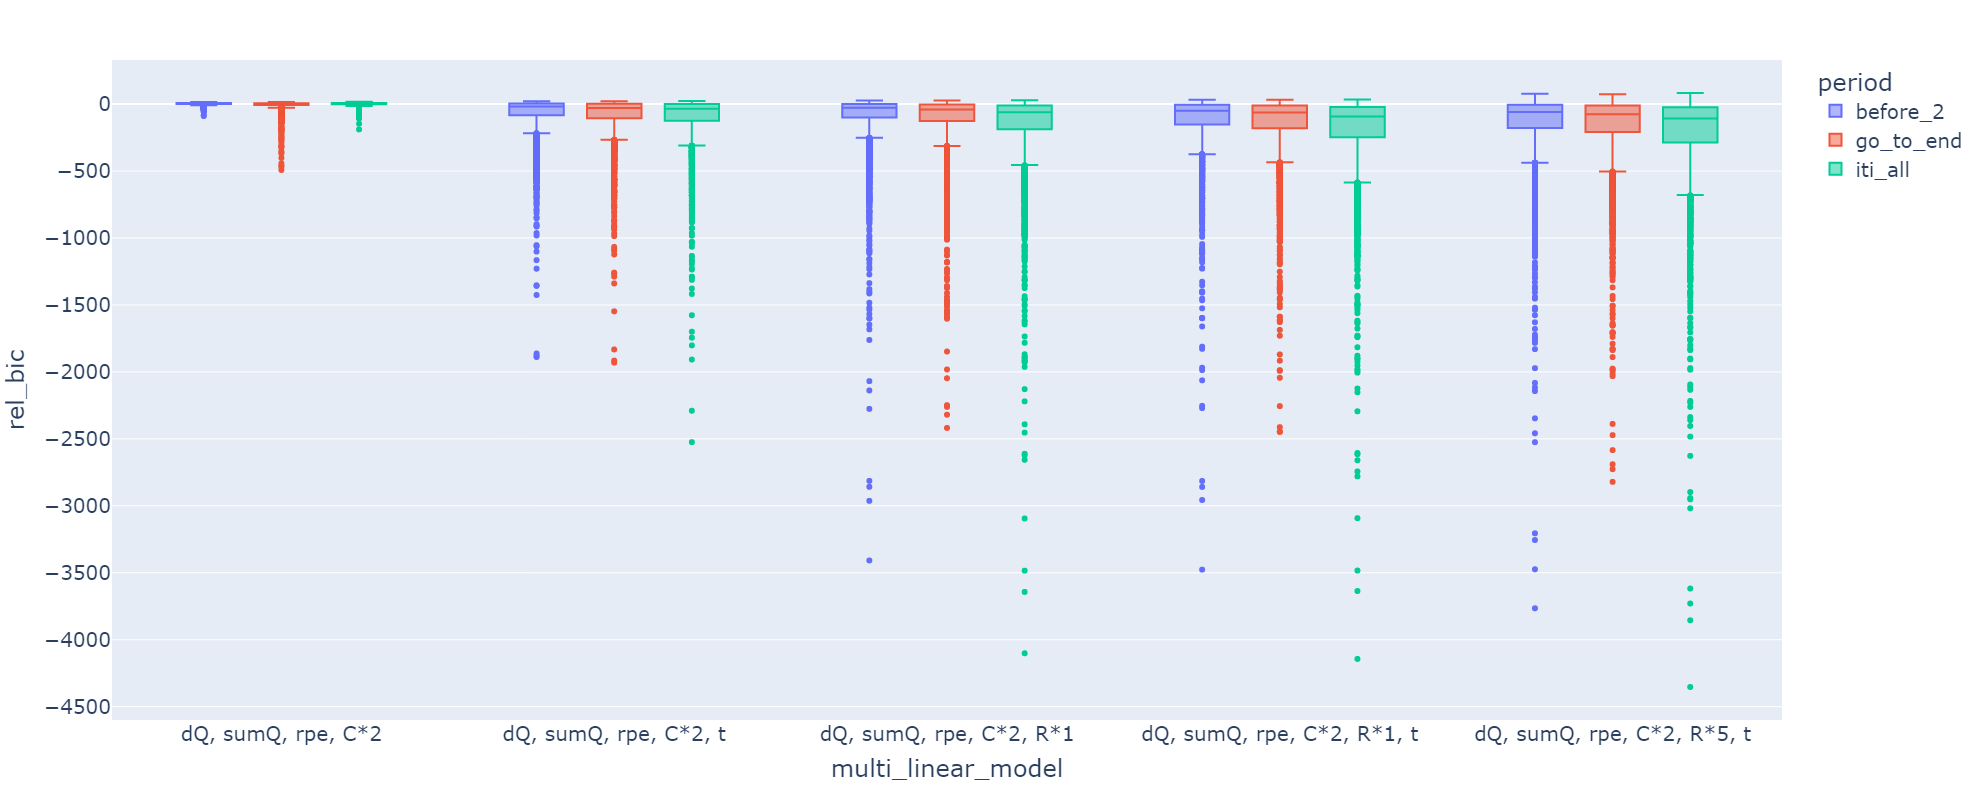

In [406]:
fig = px.box(df_period_linear_fit_melt.query('multi_linear_model in @model_order'), x='multi_linear_model', y='rel_bic', color='period')
fig.update_layout(width=800, height=800, font_size=20)
fig.update_xaxes(categoryorder='array', categoryarray=model_order)
fig.show()